### imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import convolve as sci_conv

In [2]:
def img_to_matrix(x):
    return (1 - x*1./255)[:,:,0]
def matrix_to_img(x):
    return ((1 - x)*255).astype(np.uint8).reshape(*x.shape,1).repeat(3,-1)

In [3]:
img = img_to_matrix(cv2.imread('../data/clean_finger.png'))

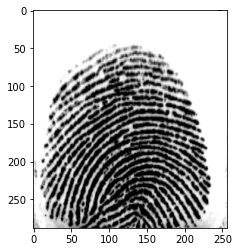

In [4]:
plt.imshow(1-img, cmap='gray')

## 4.1

In [5]:
k = np.eye(5)[::-1,:]
k[-2,2] = 1
k[-1,2] = 1
k /= 7
k

array([[0.        , 0.        , 0.        , 0.        , 0.14285714],
       [0.        , 0.        , 0.        , 0.14285714, 0.        ],
       [0.        , 0.        , 0.14285714, 0.        , 0.        ],
       [0.        , 0.14285714, 0.14285714, 0.        , 0.        ],
       [0.14285714, 0.        , 0.14285714, 0.        , 0.        ]])

#### define convolutions and check against scipy

In [6]:
def convolve(a, k):
    out = np.zeros_like(a)
    n = (len(k)-1)//2
    padded_a = np.pad(a, ((n,n),(n,n)))
    k_rev = k[::-1,::-1]
    for j in range(a.shape[1]):
        for i in range(a.shape[0]):
            out[i,j] = np.sum(padded_a[i:i+len(k),j:j+len(k)] * k_rev)  
    return out

In [7]:
 def fft_conv(a, k):
    n = (len(k)-1)//2
    padded_a = np.pad(a, ((n,n),(n,n)))
    m, n = a.shape
    padded_k = np.pad(k, ((0,m-1),(0,n-1)))
    n = (len(k)-1)//2

    return np.fft.irfft2(
        np.fft.rfft2(padded_a)*np.fft.rfft2(padded_k))[2*n:, 2*n:]

In [8]:
np.allclose(sci_conv(img, k, mode='constant') , convolve(img, k))

True

In [9]:
np.allclose(sci_conv(img, k, mode='constant') , fft_conv(img, k))

True

#### define motion+blur kernels

In [10]:
def gaussian_kernel(n, μ, σ):
    k = n//2
    x = np.array(np.meshgrid(np.arange(-k,k+1), np.arange(-k,k+1)))
    r = np.nan_to_num((x-μ.reshape(2,1,1))/σ)
    k = np.nan_to_num(np.exp(-0.5*np.sum(r*r,0))/(np.sqrt(σ*σ*2*np.pi)))
    k /= np.sum(k)
    return k

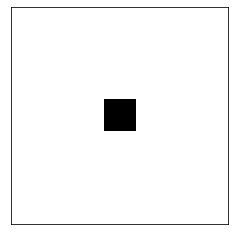

In [11]:
x = gaussian_kernel(7, np.zeros(2), 1e-12)
plt.imshow(1-x, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('gaussian_kernel_00_eps.pdf', bbox_inches='tight')
plt.show()

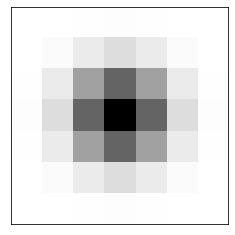

In [12]:
x = gaussian_kernel(7, np.zeros(2), 1.)
plt.imshow(1-x, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('gaussian_kernel_00_1.pdf', bbox_inches='tight')
plt.show()

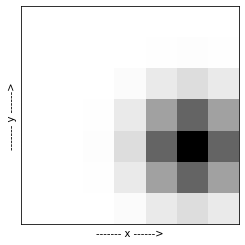

In [13]:
x = gaussian_kernel(7, np.array([2,1]), 1.)
plt.imshow(1-x, cmap='gray')
plt.xlabel('------- x ------>')
plt.ylabel('------- y ------>')
plt.xticks([])
plt.yticks([])
plt.savefig('gaussian_kernel_21_1.pdf', bbox_inches='tight')
plt.show()

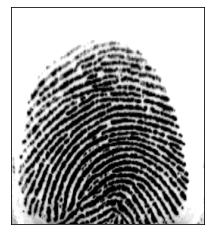

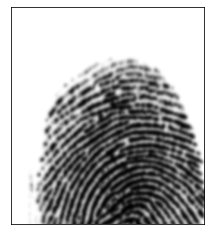

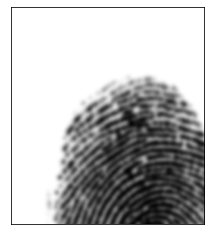

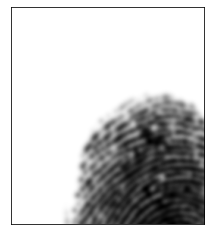

In [14]:
k = gaussian_kernel(15, 6*np.ones(2), 1)
out = img
for i in range(4):
    plt.imshow(1-out, cmap='gray');
    plt.xticks([])
    plt.yticks([])
    plt.savefig('gauss_blur_and_translate_'+str(i)+'.pdf', bbox_inches='tight')
    plt.show()
    for j in range(4):
        out = sci_conv(out, k, mode='constant')

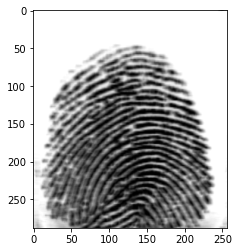

In [15]:
g_blur = gaussian_kernel(15, np.array([0,0]), 0.5)
g_move = np.array([gaussian_kernel(15, np.array([i,0]), 1e-12) for i in range(1,7)])
plt.imshow(
    1-convolve(img, 0.3*g_blur + 0.7*np.sum(g_move,0)/6), cmap='gray'
)

In [16]:
np.sum(0.3*g_blur + 0.7*np.sum(g_move,0)/6)

0.9999999999999999

### 4.2

changing energy as moves

In [17]:
def moving_energy(a):
    out = np.zeros_like(a)
    x0 = np.array([
        np.sum(np.sum(img, 1)*np.arange(img.shape[0]))/np.sum(img), 
        np.sum(np.sum(img, 0)*np.arange(img.shape[1]))/np.sum(img)
    ])
    k = gaussian_kernel(15, np.zeros(2), 1e-12)

    n = (len(k)-1)//2
    padded_a = np.pad(a, ((n,n),(n,n)))
    k = gaussian_kernel(15, np.array([0,0]).reshape(2,1,1), 1e-12)
    
    offset = 1.2
    for j in range(a.shape[1]):
        for i in range(a.shape[0]):
            dist = (np.array([i,j])-x0)/np.array([a.shape[0],a.shape[1]])
            r = np.sqrt(np.sum(np.power(dist,2)))
            #k = gaussian_kernel(15, np.zeros(2), 1e-12)
            k_rev = k[::-1,::-1]
            out[i,j] = (1-r)**2 * np.sum(padded_a[i:i+len(k),j:j+len(k)] * k_rev)
    return out

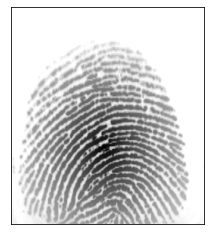

In [18]:
plt.imshow(1-moving_energy(img), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('moving_energy4_2.pdf', bbox_inches='tight')

changing blur

In [19]:
def moving_blur(a):
    out = np.zeros_like(a)
    x0 = np.array([
        np.sum(np.sum(img, 1)*np.arange(img.shape[0]))/np.sum(img), 
        np.sum(np.sum(img, 0)*np.arange(img.shape[1]))/np.sum(img)
    ])
    k = gaussian_kernel(15, np.zeros(2), 1e-12)

    n = (len(k)-1)//2
    padded_a = np.pad(a, ((n,n),(n,n)))
    k = gaussian_kernel(15, np.array([0,0]).reshape(2,1,1), 1e-12)
    
    offset = 1.2
    for j in range(a.shape[1]):
        for i in range(a.shape[0]):
            dist = (np.array([i,j])-x0)/np.array([a.shape[0],a.shape[1]])
            r = np.sqrt(np.sum(np.power(dist,2)))
            k = gaussian_kernel(15, np.zeros(2), (offset+r)**3 - offset + 1e-12)
            k_rev = k[::-1,::-1]
            out[i,j] = np.sum(padded_a[i:i+len(k),j:j+len(k)] * k_rev)
    return out

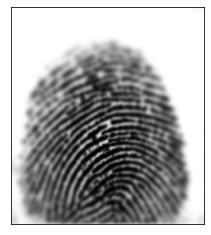

In [20]:
plt.imshow(1-moving_blur(img), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('moving_blur_4_2.pdf', bbox_inches='tight')

In [21]:
def moving_blur_and_energy(a):
    out = np.zeros_like(a)
    x0 = np.array([
        np.sum(np.sum(img, 1)*np.arange(img.shape[0]))/np.sum(img), 
        np.sum(np.sum(img, 0)*np.arange(img.shape[1]))/np.sum(img)
    ])
    k = gaussian_kernel(15, np.zeros(2), 1e-12)

    n = (len(k)-1)//2
    padded_a = np.pad(a, ((n,n),(n,n)))
    k = gaussian_kernel(15, np.array([0,0]).reshape(2,1,1), 1e-12)
    
    offset = 1.2
    for j in range(a.shape[1]):
        for i in range(a.shape[0]):
            dist = (np.array([i,j])-x0)/np.array([a.shape[0],a.shape[1]])
            r = np.sqrt(np.sum(np.power(dist,2)))
            k = gaussian_kernel(15, np.array([-1,0]), (offset+r)**3 - offset + 1e-12)
            k_rev = k[::-1,::-1]
            out[i,j] = (1-r)**2 * np.sum(padded_a[i:i+len(k),j:j+len(k)] * k_rev)
    return out

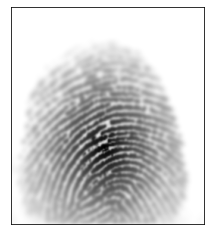

In [22]:
plt.imshow(1-moving_blur_and_energy(img), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('moving_blur_and_energy_4_2.pdf', bbox_inches='tight')

## 4.3

In [23]:
from scipy.sparse.linalg import spsolve, minres, lsqr
from scipy.sparse import csc_matrix, dia_matrix

In [24]:
clean = img_to_matrix(cv2.imread('../data/clean_blur_ex.png'))
blur = img_to_matrix(cv2.imread('../data/corrupted_blur_ex.png'))

In [25]:
k = np.eye(5)[::-1,:]
k[-2,2] = 1
k[-1,2] = 1
k /= 7
k = k[::-1,::-1]
k.round(2)

array([[0.  , 0.  , 0.14, 0.  , 0.14],
       [0.  , 0.  , 0.14, 0.14, 0.  ],
       [0.  , 0.  , 0.14, 0.  , 0.  ],
       [0.  , 0.14, 0.  , 0.  , 0.  ],
       [0.14, 0.  , 0.  , 0.  , 0.  ]])

In [26]:
from scipy.optimize import minimize

In [27]:
def conv2(a, k):
    return np.array([[np.sum(a[i:i+len(k),j:j+len(k)]*k[::-1,::-1]) for j in range(len(a)-len(k)+1)] for i in range(len(a)-len(k)+1)])

In [28]:
def obj(k):
    return np.sqrt(np.mean(np.power(blur-sci_conv(clean, k.reshape(5,5))[2:-2,2:-2],2)))

In [29]:
def obj2(k):
    return np.sqrt(np.mean(np.power(blur-sci_conv(clean, k.reshape(7,7))[2:-2,2:-2],2)))

In [30]:
obj(k)

0.06153610605171266

In [31]:
res = minimize(obj, k.flatten(), options={'maxiter':10_000})

In [32]:
k_fit = res.x.reshape(5,5)

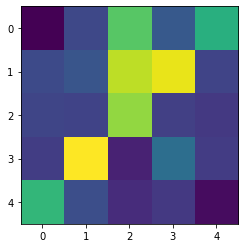

In [33]:
plt.imshow(k_fit)

In [34]:
res = minimize(obj2, np.pad(k,((1,1),(1,1))).flatten(), options={'maxiter':10_000})

In [35]:
k_fit2 = res.x.reshape(7,7)

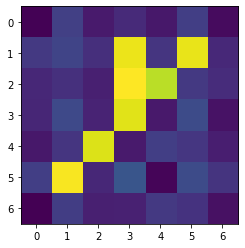

In [36]:
plt.imshow(k_fit2)

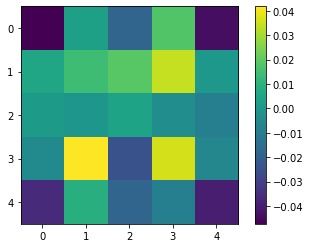

In [37]:
plt.imshow(k_fit - k); plt.colorbar()

In [38]:
obj(k_fit)

0.0298429803767047

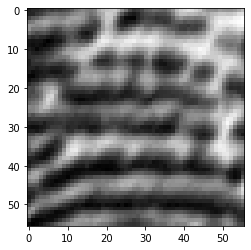

In [39]:
plt.imshow(1-blur, cmap='gray')

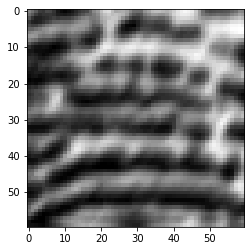

In [40]:
plt.imshow(1-sci_conv(clean, k,mode='mirror'), cmap='gray')

In [41]:
k = np.eye(5)[::-1,:]
k[-2,2] = 1
k[-1,2] = 1
k /= 7
k = k[::-1,::-1]
k.round(2)

array([[0.  , 0.  , 0.14, 0.  , 0.14],
       [0.  , 0.  , 0.14, 0.14, 0.  ],
       [0.  , 0.  , 0.14, 0.  , 0.  ],
       [0.  , 0.14, 0.  , 0.  , 0.  ],
       [0.14, 0.  , 0.  , 0.  , 0.  ]])

In [42]:
K = np.zeros((len(blur.flatten()), len(clean.flatten())))
for i in range(len(clean)-len(k)+1):
    for j in range(len(clean)-len(k)+1):
        for l in range(len(k)):
            for m in range(len(k)):
                K[i*len(blur)+j, i*len(clean)+j+l*len(clean)+m] = k[::-1,::-1][l,m]
K = csc_matrix(K)

In [43]:
np.allclose(K @ clean.flatten(), conv2(clean, k).flatten())

True

In [44]:
x = blur
n = (len(k)-1)//2
x = np.pad(x, ((n,n),(n,n)), 'edge')

In [45]:
damp_range = np.logspace(-12, 2, 50)
damp = np.array([lsqr(K, blur.flatten(), damp=d, x0=x.flatten())[3:5] for d in damp_range])

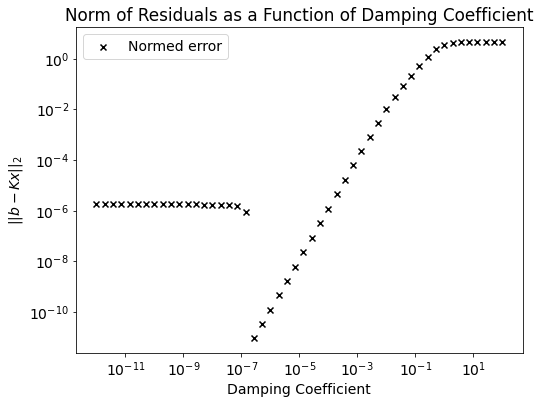

In [46]:
plt.figure(figsize=(8,6))
plt.rcParams.update({'font.size':14})
plt.scatter(damp_range, damp[:,0], marker='x', color='black', label='Normed error')
plt.loglog();
plt.title('Norm of Residuals as a Function of Damping Coefficient')
plt.xlabel('Damping Coefficient')
plt.ylabel(r'$||b - K x||_2$')
plt.savefig('normed_error_on_residuals_damping_coeff.pdf', bbox_inches='tight')
plt.legend();

In [47]:
out = lsqr(K, blur.flatten(), damp=damp_range[np.argmin(damp)], x0=x.flatten())

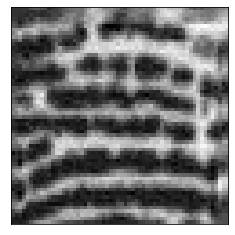

In [48]:
plt.imshow(1-out[0].reshape(*clean.shape), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('matrix_solve_k.pdf', bbox_inches='tight')

In [49]:
o = out[0].reshape(*clean.shape)

In [50]:
def obj3(x):
    return np.linalg.norm(o-sci_conv(o, gaussian_kernel(5,np.zeros(2), x)))

In [51]:
res = minimize(obj3, 0.9)

In [52]:
res

      fun: 0.0
 hess_inv: array([[1]])
      jac: array([0.])
  message: 'Optimization terminated successfully.'
     nfev: 4
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([-0.11])

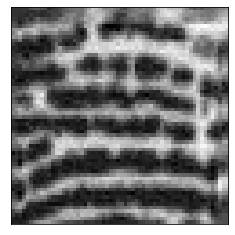

In [53]:
plt.imshow(1-sci_conv(o, gaussian_kernel(5,np.zeros(2), res.x)), cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('matrix_solve_k_gauss_smoothed.pdf', bbox_inches='tight')

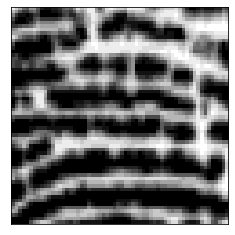

In [54]:
plt.imshow(1-clean, cmap='gray')
plt.xticks([])
plt.yticks([])
plt.savefig('clean_image.pdf', bbox_inches='tight')

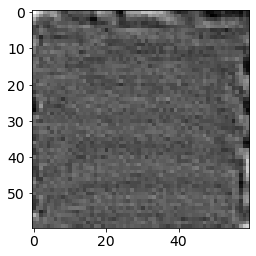

In [55]:
plt.imshow(1-(clean-o), cmap='gray')

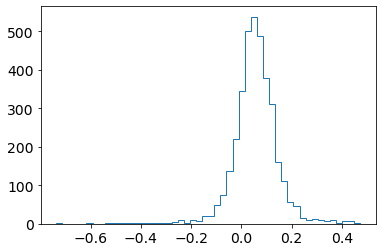

In [56]:
plt.hist((clean-o).flatten(), bins=50, histtype='step');

In [57]:
np.mean(clean-o)

0.054264870649566414

In [58]:
np.std(clean-o)

0.09130219670503287

In [59]:
imgs = np.array([o + np.random.normal(scale=0.1, size=o.shape) for i in range(2)])

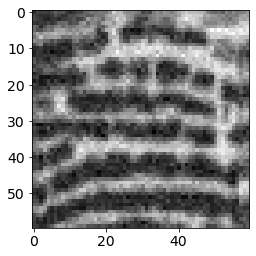

In [60]:
plt.imshow(1-np.mean(imgs,0), cmap='gray')

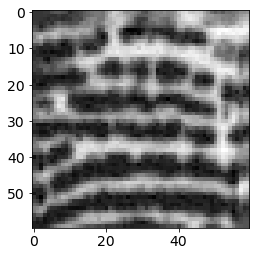

In [61]:
plt.imshow(1-(np.max(np.array([o,sci_conv(o,gaussian_kernel(5,np.zeros(2),.5))]),0)), cmap='gray')

In [62]:
K = np.zeros((len(blur.flatten()), len(clean.flatten())))
for i in range(len(clean)-len(k)+1):
    for j in range(len(clean)-len(k)+1):
        for l in range(len(k)):
            for m in range(len(k)):
                K[i*len(blur)+j, i*len(clean)+j+l*len(clean)+m] = k[::-1,::-1][l,m]

In [63]:
K = csc_matrix(K)

In [64]:
np.allclose(K @ clean.flatten(), conv2(clean, k).flatten())

True

In [65]:
x = blur
n = (len(k)-1)//2
x = np.pad(x, ((n,n),(n,n)), 'edge')

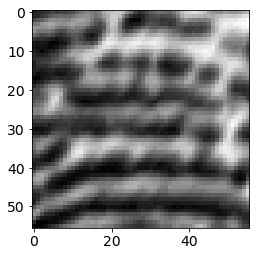

In [66]:
plt.imshow(1 - blur, cmap='gray')

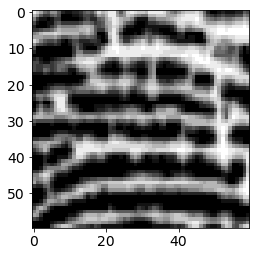

In [67]:
plt.imshow(1-clean, cmap='gray')

In [68]:
K = np.zeros((len(blur.flatten()), len(clean.flatten())))
for i in range(len(clean)-len(k)+1):
    for j in range(len(clean)-len(k)+1):
        for l in range(len(k)):
            for m in range(len(k)):
                K[i*len(blur)+j, i*len(clean)+j+l*len(clean)+m] = k[::-1,::-1][l,m]

In [69]:
l = 1.
K_p = np.append(K, l*np.eye(3600), 0)
b = np.append(blur.flatten(), np.zeros(3600))
K_p = csc_matrix(K_p)

In [70]:
out = spsolve(K_p.T@K_p, K_p.T @ b)

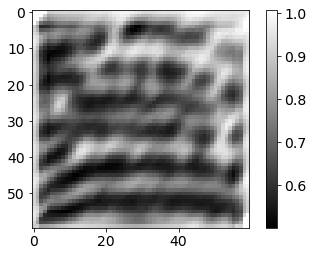

In [71]:
plt.imshow(1-out.reshape(*clean.shape), cmap='gray')
plt.colorbar();

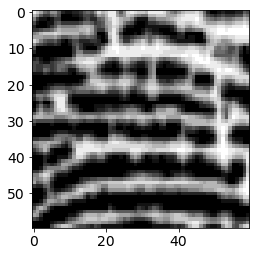

In [72]:
plt.imshow(1-clean, cmap='gray')

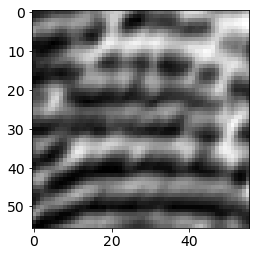

In [73]:
plt.imshow(1 - (K_p @ clean.flatten())[:np.prod(blur.shape)].reshape(*blur.shape), cmap='gray')

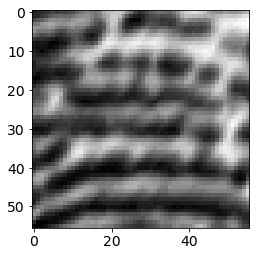

In [74]:
plt.imshow(1 - blur, cmap='gray')

### Wiener filtering

In [214]:
clean = img_to_matrix(cv2.imread('../data/clean_blur_ex.png'))
blur = img_to_matrix(cv2.imread('../data/corrupted_blur_ex.png'))

In [235]:
a = blur
n = (len(k)-1)//2
padded_a = np.pad(a, ((n,n),(n,n)))
m, n = a.shape
padded_k = np.pad(k, ((0,m-1),(0,n-1)))
n = (len(k)-1)//2

kernel_hat = np.fft.fft2(padded_k)
blur_hat = np.fft.fft2(padded_a)

In [236]:
kernel_hat[np.abs(kernel_hat)<1e-4] = 1e-4 + 1e-4j

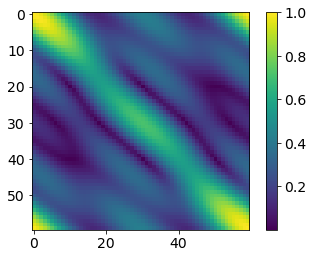

In [237]:
plt.imshow(np.abs(kernel_hat)); plt.colorbar()

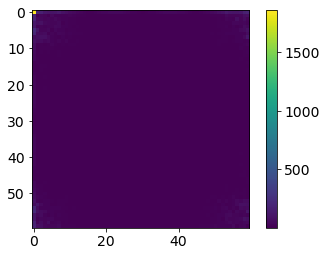

In [238]:
plt.imshow(np.abs(blur_hat)); plt.colorbar()

In [239]:
product_hat = blur_hat / kernel_hat

In [241]:
product = np.fft.ifft2(product_hat)

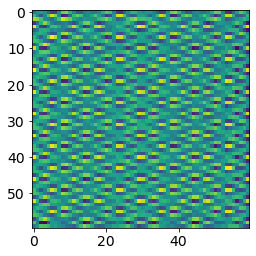

In [245]:
plt.imshow(product.real)

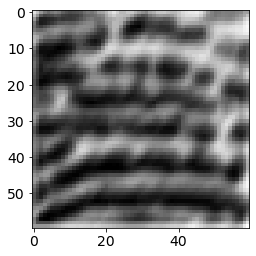

In [204]:
plt.imshow(1-approx, cmap='gray')

In [151]:
clean_hat = np.fft.fft2(clean)
blur_hat = np.fft.fft2(blur)

In [ ]:
approx = np.fft.irfft2(
    np.fft.rfft2(blur) / np.fft.rfft2(np.pad

In [152]:
clean_ps = np.log(2*np.abs(clean_hat)**2)
blur_ps = np.log(2*np.abs(blur_hat)**2)

In [153]:
M, N = clean_ps.shape
ind = tuple(np.meshgrid(np.arange(-M//2,M//2), np.arange(-N//2,N//2)))
clean_ps = clean_ps[ind]
clean_x = np.arange(-M//2,M//2)/M

In [154]:
M, N = blur_ps.shape
ind = tuple(np.meshgrid(np.arange(-M//2,M//2), np.arange(-N//2,N//2)))
blur_ps = blur_ps[ind]
blur_x = np.arange(-M//2,M//2)/M

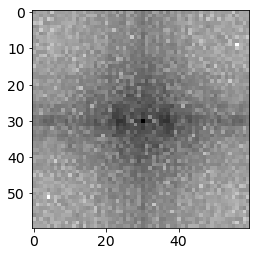

In [155]:
plt.imshow(1-clean_ps, cmap='gray')

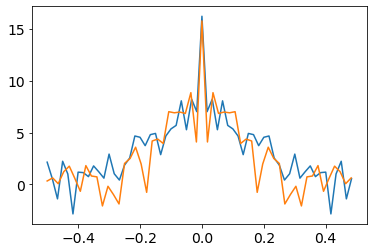

In [156]:
plt.plot(clean_x, clean_ps.diagonal(), label='diagonal of clean power spectrum')
plt.plot(blur_x, blur_ps.diagonal(), label='diagonal of blurred power spectrum')

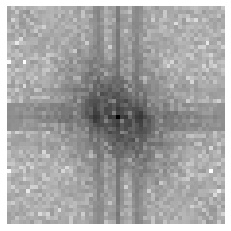

In [246]:
fig, ax = plt.subplots()
ax.imshow(1-blur_ps, cmap='gray')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.savefig('blurred_power_spectrum.pdf', bbox_inches='tight')
plt.show()

In [252]:
clean_ps[0,0]

2.1450211873258147

In [253]:
blur_ps[0,0]

0.33320442166195746

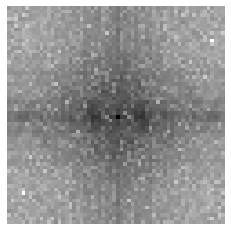

In [247]:
fig, ax = plt.subplots()
ax.imshow(1-clean_ps, cmap='gray')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.yticks([])
plt.savefig('clean_power_spectrum.pdf', bbox_inches='tight')
plt.show()

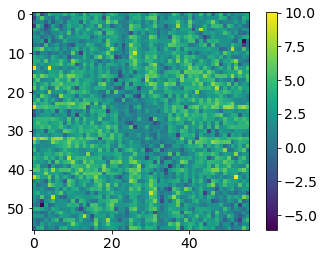

In [160]:
plt.imshow(1-(blur_ps-clean_ps[2:-2,2:-2])); plt.colorbar()

### Misc

In [75]:
@np.vectorize
def bump_function(x, x0, r, α, scale=1):
    if np.linalg.norm(x-x0) >= r:
        return 0.
    return scale*np.exp(-α/(r*r-(x-x0)**2) + α/r/r)

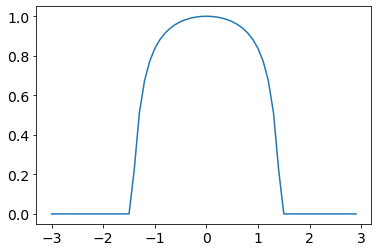

In [76]:
x = np.arange(-3,3,1e-1)
plt.plot(x, bump_function(x,0.,1.5,0.5))

In [77]:
from scipy.optimize import minimize, curve_fit

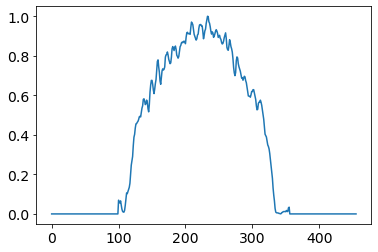

In [78]:
x = np.arange(img.shape[1]+200)
y = np.pad(np.sum(img, 0), (100,100))
y /= np.max(y)
plt.plot(x, y)

In [79]:
popt, pcov = curve_fit(bump_function, x, y, p0=[250, 100, 0.5, 1.])

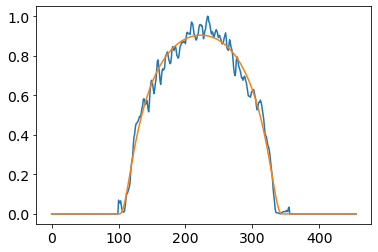

In [80]:
plt.plot(x, y, label='data')
plt.plot(x, bump_function(x, *popt))